## Edge detection 평가 방법
1. Quantitative (정량적 평가)

정확도(Accuracy): 이는 실제 엣지와 검출된 엣지 간의 일치도를 측정합니다. 정확도는 일반적으로 True Positive, False Positive, True Negative, False Negative를 기반으로 계산됩니다.

재현율(Recall) 및 정밀도(Precision): 재현율은 실제 엣지 중에서 검출된 엣지의 비율을 나타내며, 정밀도는 검출된 엣지 중 실제 엣지의 비율을 나타냅니다.

F-점수(F-Score): 이는 재현율과 정밀도의 조화 평균을 나타냅니다. F-점수는 엣지 검출의 전반적인 정확도를 평가하는 데 유용합니다.

PSNR과 SSIM: 이미지 품질 측정 지표로, 엣지 검출의 품질을 평가하는 데 사용될 수 있습니다.


2. Qualitative (정성적 평가)

### 고려해야 할 것 
- 알고리즘별 처리시간, 정확도(f1, auc), 밝기 민감도, houghline, .. ?

- 요소별로 가중치 주어서 자동으로 최적의 알고리즘 도출

- 알고리즘별 우선 순위 부여 

References 
- Efficient facet edge detection and quantitative performance evaluation
- Contextual and non-contextual performance evaluation of edge detectors

edge detector evaluation method review paper

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9454489

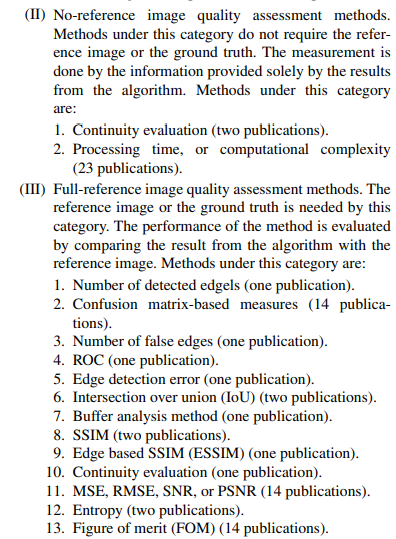

### 1. 엣지의 연속성(continuity)

- J. Wu, G. Xu, and D. Chen. “One Valid Framework of Integrating
Intensity Discontinuity and Edge Continuity for Image Straight-Line
Extraction”. In: 2009 First International Conference on Information
Science and Engineering. Dec. 2009, pp. 1356–1359. doi: 10.1109/
ICISE.2009.803.

- S Susan, P Agrawal, M Mittal… - CAAI Transactions on …, 2019 - Wiley Online Library : New shape descriptor in the context of edge continuity

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cap = cv2.VideoCapture(1)
ret, frame = cap.read()

In [3]:
frame.shape
len(frame.shape)

3

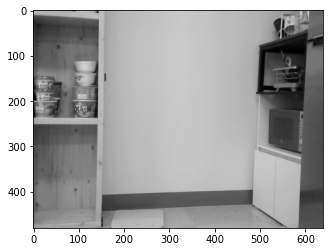

In [4]:
frame_gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(frame_gray, cmap='gray')

In [5]:
def find_edges(img) : 
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else :
        gray = img.copy()
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    edge = cv2.Canny(blur, 100, 200)
    return edge

def measure_continuity(edges, max_gap=5):
    # 연속성을 확인하기 위해 엣지 픽셀의 좌표를 찾음
    y_coords, x_coords = np.where(edges == 255)
    edge_points = list(zip(x_coords, y_coords))

    # 각 엣지 픽셀에 대해 이전 픽셀과의 거리를 계산
    distances = [np.sqrt((x - edge_points[i - 1][0])**2 + (y - edge_points[i - 1][1])**2) 
                 for i, (x, y) in enumerate(edge_points) if i > 0]

    # 거리가 max_gap 이하인 경우를 연속적인 것으로 간주
    continuous_edges = sum(d <= max_gap for d in distances)
    total_edges = len(distances)

    # 연속성 비율 계산
    continuity_ratio = continuous_edges / total_edges if total_edges > 0 else 0
    return continuity_ratio

In [6]:
edge = find_edges(frame)
continuity = measure_continuity(edge)
print(f"continuity ratio of detected edge : {continuity}")

continuity = measure_continuity(edge, 10)
print(f"continuity ratio of detected edge : {continuity}")

continuity ratio of detected edge : 0.6333732057416268
continuity ratio of detected edge : 0.6686602870813397


In [7]:
y_coords, x_coords = np.where(edge == 255)
edge_points = list(zip(x_coords, y_coords))

distances = [np.sqrt((x - edge_points[i - 1][0])**2 + (y - edge_points[i - 1][1])**2) 
             for i, (x, y) in enumerate(edge_points) if i > 0]

# 평균 디스턴스 
np.mean(distances)

74.61487412206426

### 2. 엣지의 명확성 (clarity)
주로 엣지가 얼마나 뚜렷하고 선명한지를 측정 // 엣지의 강도나 대비 분석 

In [8]:
# def calculate_edge_clarity(image, edges):
#     # 엣지 픽셀 좌표
#     y_coords, x_coords = np.where(edges == 255)
#     edge_points = list(zip(x_coords, y_coords))

#     # 엣지 주변의 밝기 차이 계산
#     edge_gradients = []
#     for x, y in edge_points:
#         # 중심 픽셀과 주변 픽셀 간의 밝기 차이
#         center_intensity = image[y, x]
#         for dx in range(-1, 2):
#             for dy in range(-1, 2):
#                 if dx == 0 and dy == 0:
#                     continue
#                 nx, ny = x + dx, y + dy
#                 if 0 <= nx < image.shape[1] and 0 <= ny < image.shape[0]:
#                     neighbor_intensity = image[ny, nx]
#                     edge_gradients.append(abs(int(center_intensity) - int(neighbor_intensity)))

#     # 평균 또는 중앙값 엣지 그라디언트 계산
#     if edge_gradients:
#         clarity_score = np.mean(edge_gradients) / 255
#         # clarity_score = np.median(edge_gradients)  # 중앙값 사용 시
#     else:
#         clarity_score = 0

#     return clarity_score



In [9]:
# clarity_score = calculate_edge_clarity(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), edge)
# print(f"Edge Clarity Score: {clarity_score}")

### 3. noise 강인성 
noise 추가 후 강인성 확인 

In [10]:
def add_gaussian_noise(image, mean=0, sigma=5):
    """ 가우시안 잡음 추가 """
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image

def add_salt_and_pepper_noise(image, salt_pepper_ratio=0.5, amount=0.02):
    """ 소금-후추 잡음 추가 """
    noisy = np.copy(image)
    num_salt = np.ceil(amount * image.size * salt_pepper_ratio)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_pepper_ratio))

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[coords] = 1

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[coords] = 0
    return noisy

def compare_edges(original_edges, noisy_edges):
    """ 두 엣지 검출 결과 비교 """
    # absdiff -> 두 이미지간 절대 차이를 픽셀별로 계산 
    difference = cv2.absdiff(original_edges, noisy_edges)
    # np.sum() -> 픽셀 차이 총합 계산 (총 차이) , np.size() -> 픽셀 평균 차이 
    score = np.sum(difference) / np.size(difference)
    # 차이값 score 낮을수록 좋은거
    normalized_score = score / 255  # 정규화
    return 1- normalized_score

# 잡음 추가 및 엣지 검출
gauss_noisy_image = add_gaussian_noise(frame)
impulse_noisy_image = add_salt_and_pepper_noise(frame)
gauss_noisy_edges = find_edges(gauss_noisy_image)
impulse_noisy_edges = find_edges(impulse_noisy_image)


# 두 엣지 검출 결과 비교
noise_robustness_score = compare_edges(edge, gauss_noisy_edges)
print("Gauss Noise Robustness Scores:", noise_robustness_score)

noise_robustness_score = compare_edges(edge, impulse_noisy_edges)
print("Impulse Noise Robustness Scores:", noise_robustness_score)

Gauss Noise Robustness Scores: 0.7783170572916667
Impulse Noise Robustness Scores: 0.9934342447916666


C:\Users\yeseul\AppData\Local\Temp\ipykernel_20372\1376008218.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noisy[coords] = 1
C:\Users\yeseul\AppData\Local\Temp\ipykernel_20372\1376008218.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noisy[coords] = 0


### 4. 밝기 (intensity), 대조(contrast) 변화 강인성 

SSIM (Structural Similarity Index Measure)은 이미지의 품질을 평가하는 데 사용되는 메트릭으로, 두 이미지 간의 구조적 유사성을 측정

이미지의 밝기, 대비, 구조의 세 가지 요소를 고려하여 두 이미지 간의 유사성을 평가
SSIM은 0과 1 사이의 값으로 표현되며, 1은 두 이미지가 완벽하게 일치함을 나타냄. 

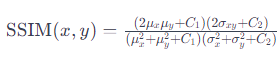



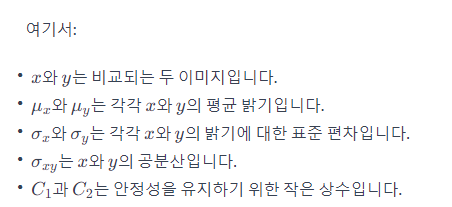

SSIM의 의미
- 높은 SSIM 값 (가까이 1): 두 이미지는 구조적으로 매우 유사합니다. 이는 왜곡이 거의 없거나 아주 적다는 것을 의미합니다.
- 낮은 SSIM 값: 두 이미지 사이에 큰 구조적 차이가 있습니다. 이는 왜곡이 심하거나 이미지가 서로 다르다는 것을 나타냅니다.

`Edge Based Structural Similarity Index (ESSIM)`는 전통적인 SSIM (Structural Similarity Index Measure)에 엣지(edge) 정보를 추가한 변형

이미지의 밝기(luminance), 대비(contrast), 그리고 엣지 정보를 고려함

In [11]:
from skimage.metrics import structural_similarity as compare_ssim
import cv2
import numpy as np

def compute_luminance(img1, img2):
    return np.mean(img1), np.mean(img2)

def compute_contrast(img1, img2):
    return np.std(img1), np.std(img2)

def compute_essim(img1, img2):
    luminance1, luminance2 = compute_luminance(img1, img2)
    contrast1, contrast2 = compute_contrast(img1, img2)
    edges1, edges2 = find_edges(img1), find_edges(img2)

    l = (2 * luminance1 * luminance2 + 0.01) / (luminance1**2 + luminance2**2 + 0.01)
    c = (2 * contrast1 * contrast2 + 0.03) / (contrast1**2 + contrast2**2 + 0.03)
    e = compare_ssim(edges1, edges2)

    return l * 0.33 + c * 0.33 + e * 0.33

In [12]:
from skimage.metrics import structural_similarity as compare_ssim
import cv2

def calculate_ssim(image1, image2):
    return compare_ssim(image1, image2)

# SSIM 계산
ssim_value = calculate_ssim(frame_gray, edge)
print(f"SSIM between the original and edge detected images: {ssim_value}")

SSIM between the original and edge detected images: 0.0027033993187863207


0.912890625
0.8767333984375
Performance Consistency Scores: {'Brightness': {0.25: 0.8611328125, 0.5: 0.9323893229166667, 1.5: 0.9457356770833333, 2: 0.9123046875}, 'Contrast': {0.1: 0.8366861979166667, 0.5: 0.8654622395833333, 1.5: 0.93037109375, 2: 0.8744140625}}
Harmonic mean : 0.8944467548224493


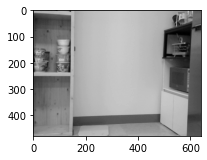

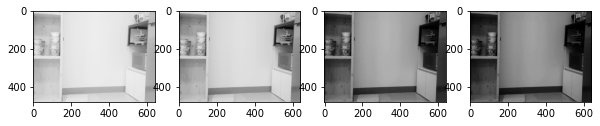

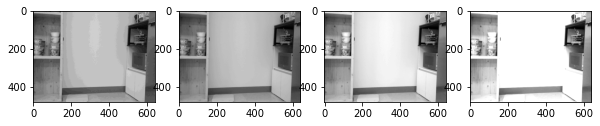

In [13]:
def adjust_brightness(image, gamma):
    """ 이미지의 밝기 조절 """
    return np.array(255 * (image / 255) ** gamma, dtype='uint8')

def adjust_contrast(image, contrast_factor):
    """ 이미지의 대비 조절 """
    adjusted = cv2.multiply(image, contrast_factor)
    return adjusted


def compare_adjusted_edges(original_edges, adjusted_edges):
    """ 두 엣지 검출 결과 비교 """
    # absdiff -> 두 이미지간 절대 차이를 픽셀별로 계산 
    difference = cv2.absdiff(original_edges, adjusted_edges)
    # np.sum() -> 픽셀 차이 총합 계산 (총 차이) , np.size() -> 픽셀 평균 차이 
    score = np.sum(difference) / np.size(difference)
    # 차이값 score 낮을수록 좋은거
    normalized_score = score / 25.5  # 정규화
    final_score = 1- normalized_score
    return final_score

# 밝기 및 대비 조절
brightness_factors = [0.25, 0.5, 1.5, 2]  # 밝기 조절 계수
contrast_factors = [0.1, 0.5, 1.5, 2]    # 대비 조절 계수

results = {'Brightness': {}, 'Contrast': {}}

plt.figure(figsize=(3, 3))
plt.imshow(frame_gray,cmap='gray')

plt.figure(figsize=(10, 10))

# 밝기 조절 이미지에 대한 엣지 검출 및 비교
for i, b in enumerate(brightness_factors) :
    bright_image = adjust_brightness(frame, b)
    bright_edges = find_edges(bright_image)
    
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2GRAY),cmap='gray')
    results['Brightness'][b] = compare_adjusted_edges(edge, bright_edges)

print(np.mean(list(results['Brightness'].values())))
b_mean = np.mean(list(results['Brightness'].values()))
plt.figure(figsize=(10, 10))
    
# 대비 조절 이미지에 대한 엣지 검출 및 비교
for i, c in enumerate(contrast_factors) :
    contrast_image = adjust_contrast(frame, c)
    contrast_edges = find_edges(contrast_image)
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(contrast_image, cv2.COLOR_BGR2GRAY),cmap='gray')
    results['Contrast'][c] = compare_adjusted_edges(edge, contrast_edges)

print(np.mean(list(results['Contrast'].values())))
c_mean = np.mean(list(results['Contrast'].values()))
    
print("Performance Consistency Scores:", results)

# harmonic mean
print("Harmonic mean :", (b_mean * c_mean * 2) / (b_mean + c_mean))


{'Brightness': {0.25: 0.787658035509925,
  0.5: 0.9694560428876,
  1.5: 0.9651383787187839,
  2: 0.9184321072281874},
 'Contrast': {0.25: 0.2859665483467064,
  0.5: 0.6509837476794916,
  1.5: 0.9509040474440463,
  2: 0.9397178324919158}}

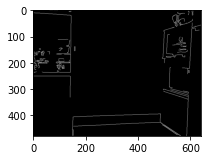

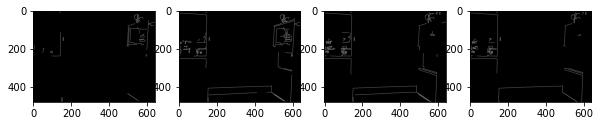

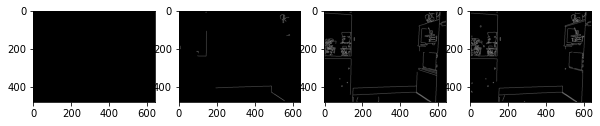

In [14]:
# 밝기 및 대비 조절
brightness_factors = [0.25, 0.5, 1.5, 2]  # 밝기 조절 계수
contrast_factors = [0.25, 0.5, 1.5, 2]    # 대비 조절 계수

results = {'Brightness': {}, 'Contrast': {}}

plt.figure(figsize=(3, 3))
plt.imshow(find_edges(frame),cmap='gray')

plt.figure(figsize=(10, 10))

# 밝기 조절 이미지에 대한 엣지 검출 및 비교
for i, b in enumerate(brightness_factors) :
    bright_image = adjust_brightness(frame, b)
    bright_edges = find_edges(bright_image)
    
    plt.subplot(1, 4, i+1)
    plt.imshow(bright_edges,cmap='gray')
    results['Brightness'][b] = compute_essim(edge, bright_edges)

plt.figure(figsize=(10, 10))
    
# 대비 조절 이미지에 대한 엣지 검출 및 비교
for i, c in enumerate(contrast_factors) :
    contrast_image = adjust_contrast(frame, c)
    contrast_edges = find_edges(contrast_image)
    plt.subplot(1, 4, i+1)
    plt.imshow(contrast_edges,cmap='gray')
    results['Contrast'][c] = compute_essim(edge, contrast_edges)

    
results

consistency score : 0.9323893229166667
consistency score : 1.0
consistency score : 0.9457356770833333


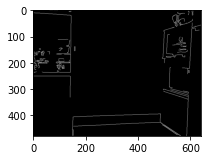

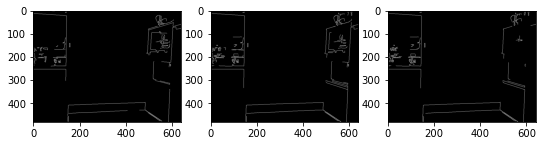

In [15]:
plt.figure(figsize=(3, 3))
plt.imshow(edge,cmap='gray')

plt.figure(figsize=(9,9))
bright_image = adjust_brightness(frame, 0.5)
bright_edges = find_edges(bright_image)
plt.subplot(1,3,1)
plt.imshow(bright_edges,cmap='gray')

print("consistency score :",compare_adjusted_edges(edge, bright_edges))

bright_image = adjust_brightness(frame, 1.)
bright_edges = find_edges(bright_image)
plt.subplot(1,3,2)
plt.imshow(bright_edges,cmap='gray')

print("consistency score :",compare_adjusted_edges(edge, bright_edges))

bright_image = adjust_brightness(frame, 1.5)
bright_edges = find_edges(bright_image)
plt.subplot(1,3,3)
plt.imshow(bright_edges,cmap='gray')

print("consistency score :",compare_adjusted_edges(edge, bright_edges))

## PSNR (최대 신호 대 잡음비, Peak Signal-to-Noise Ratio) 
이미지나 비디오 품질 평가에 사용되는 metric으로, 원본 신호와 손실/왜곡이 있는 신호 사이 품질의
차이를 수치화한다. PSNR은 신호의 최대 가능 파워와 신호 손실을 나타내는 노이즈의 파워 사이 비율을
로그 스케일로 나타낸다. 

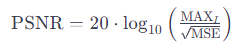

PSNR 값이 높을수록 원본 이미지와 왜곡된 이미지 사이의 차이가 적다는 것을 의미하며, 일반적으로 더 높은 이미지 품질을 나타낸다. 

PSNR 값은 다음과 같이 해석될 수 있다. 
- 40dB 이상: 훌륭한 품질
- 30dB - 40dB: 양호한 품질
- 20dB - 30dB: 낮은 품질
- 20dB 이하: 매우 낮은 품질

In [16]:
import cv2
import numpy as np

# PSNR 계산 함수
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def psnr_noisy_img(img) :
    noise = np.random.normal(0, 25, frame.shape)
    noisy_img = frame + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    
    edge = find_edges(img)
    edges_noisy = find_edges(noisy_image)
    
    psnr_value = calculate_psnr(edge, edges_noisy)
    return psnr_value

# 잡음 추가
noise = np.random.normal(0, 25, frame.shape)
noisy_image = frame + noise
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

# 잡음 있는 이미지에 대한 엣지 검출
edges_noisy = find_edges(noisy_image)

# PSNR 계산
psnr_value = calculate_psnr(edge, edges_noisy)

psnr_noisy_img(frame)
print(f"PSNR between edges of original and noisy images: {psnr_value} dB")

PSNR between edges of original and noisy images: 67.58548097769149 dB


## 평가 종합

In [17]:
def evaluate_all(img) :
    """edge detecting method 정의"""
    
    """continuity of edges""" 
    edge = find_edges(img)
    continuity = measure_continuity(edge)
    
#     """clarity of edges"""
#     clarity_score = calculate_edge_clarity(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), edge)

    """noise robustness of edges""" 
    gauss_noisy_image = add_gaussian_noise(img)
    impulse_noisy_image = add_salt_and_pepper_noise(img)
    gauss_noisy_edges = find_edges(gauss_noisy_image)
    impulse_noisy_edges = find_edges(impulse_noisy_image)

    gauss_noise_robustness_score = compare_edges(edge, gauss_noisy_edges)
    impulse_noise_robustness_score = compare_edges(edge, impulse_noisy_edges)
    
    """PSNR"""
    psnr_noisy_img(frame)
#     print(f"PSNR between edges of original and noisy images: {psnr_value} dB")
    
    """intensity, contrast robustness of edges"""
    
    brightness_factors = [0.5, 1, 1.5]  # 밝기 조절 계수
    contrast_factors = [0.5, 1, 1.5]    # 대비 조절 계수
    
    results = {'Brightness': {}, 'Contrast': {}}

    for b in brightness_factors:
        bright_image = adjust_brightness(img, b)
        bright_edges = find_edges(bright_image)
        results['Brightness'][b] = compare_adjusted_edges(edge, bright_edges)
    
    for c in contrast_factors:
        contrast_image = adjust_contrast(img, c)
        contrast_edges = find_edges(contrast_image)
        results['Contrast'][c] = compare_adjusted_edges(edge, contrast_edges)
    
    b_mean = np.mean(list(results['Brightness'].values()))
    c_mean = np.mean(list(results['Contrast'].values()))
    harmonic_mean = (b_mean * c_mean * 2) / (b_mean + c_mean)
    
    
    print(f"1. continuity score : {continuity:.2f}")
    print(f"2. PNSR : {psnr_value * 0.01 :.2f}")
#     print(f"2. clarity score : {clarity_score:.2f}")    
    print(f"3. noise robustness score : {(gauss_noise_robustness_score + impulse_noise_robustness_score) /2 :.2f}") 
    noise_robust_val = (gauss_noise_robustness_score + impulse_noise_robustness_score) /2
    print(f"4. intensity, contrast robustness score : {harmonic_mean}")
    
    return (continuity * 0.25) + (psnr_value * 0.01 * 0.25) + (noise_robust_val * 0.25) + (harmonic_mean * 0.25)
    

In [18]:
evaluate_all(frame)

1. continuity score : 0.63
2. PNSR : 0.68
3. noise robustness score : 0.89
4. intensity, contrast robustness score : 0.9454608041123553


C:\Users\yeseul\AppData\Local\Temp\ipykernel_20372\1376008218.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noisy[coords] = 1
C:\Users\yeseul\AppData\Local\Temp\ipykernel_20372\1376008218.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  noisy[coords] = 0


0.7850243370691825

In [19]:
im0 = cv2.imread("./data/test2/2023-12-21-174303.jpg")
im1 = cv2.imread("./data/test2/2023-12-21-174235.jpg")
im2 = cv2.imread("./data/test2/2023-12-21-174239.jpg")
im3 = cv2.imread("./data/test2/2023-12-21-174244.jpg")
im4 = cv2.imread("./data/test2/2023-12-21-174433.jpg")
im5 = cv2.imread("./data/test2/2023-12-21-174430.jpg")
im6 = cv2.imread("./data/test2/2023-12-21-174438.jpg")
im7 = cv2.imread("./data/test2/2023-12-21-174415.jpg")
im8 = cv2.imread("./data/test2/2023-12-21-174248.jpg")
im9 = cv2.imread("./data/test2/2023-12-21-174252.jpg")

im0_gray = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
im3_gray = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
im4_gray = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)
im5_gray = cv2.cvtColor(im5, cv2.COLOR_BGR2GRAY)
im6_gray = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
im7_gray = cv2.cvtColor(im7, cv2.COLOR_BGR2GRAY)
im8_gray = cv2.cvtColor(im8, cv2.COLOR_BGR2GRAY)
im9_gray = cv2.cvtColor(im9, cv2.COLOR_BGR2GRAY)

ssim_value = compute_essim(im0_gray, im9_gray)
# i , c , e 
print(f"SSIM between the original and edge detected images: {ssim_value}")

SSIM between the original and edge detected images: 0.6144649033560983


In [20]:
edge0=find_edges(im0_gray)
edge1=find_edges(im1_gray)
edge2=find_edges(im2_gray)
edge3=find_edges(im3_gray)
edge4=find_edges(im4_gray)
edge5=find_edges(im5_gray)
edge6=find_edges(im6_gray)
edge7=find_edges(im7_gray)
edge8=find_edges(im8_gray)
edge9=find_edges(im9_gray)

essim_value = compute_essim(edge0, edge9)
print(f"essim between the original and edge detected images: {essim_value}")

essim_value = compute_essim(edge0, edge8)
print(f"essim between the original and edge detected images: {essim_value}")

essim_value = compute_essim(edge0, edge7)
print(f"essim between the original and edge detected images: {essim_value}")

essim_value = compute_essim(edge0, edge6)
print(f"essim between the original and edge detected images: {essim_value}")

essim_value = compute_essim(edge0, edge5)
print(f"essim between the original and edge detected images: {essim_value}")

essim_value = compute_essim(edge0, edge4)
print(f"essim between the original and edge detected images: {essim_value}")

essim_value = compute_essim(edge0, edge3)
print(f"essim between the original and edge detected images: {essim_value}")

essim_value = compute_essim(edge0, edge2)
print(f"essim between the original and edge detected images: {essim_value}")

essim_value = compute_essim(edge0, edge1)
print(f"essim between the original and edge detected images: {essim_value}")


essim between the original and edge detected images: 0.4150260506102112
essim between the original and edge detected images: 0.3625191377333885
essim between the original and edge detected images: 0.4530457828679684
essim between the original and edge detected images: 0.7823362849422177
essim between the original and edge detected images: 0.5412567921550745
essim between the original and edge detected images: 0.5538931653673841
essim between the original and edge detected images: 0.9567093386465724
essim between the original and edge detected images: 0.9814381791164792
essim between the original and edge detected images: 0.9765246031939738


In [21]:
from sklearn.metrics import roc_auc_score
def calculate_metrics(gt, edge_detected):
    TP = np.sum((gt == 255) & (edge_detected == 255))
    FP = np.sum((gt == 0) & (edge_detected == 255))
    FN = np.sum((gt == 255) & (edge_detected == 0))
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # harmonic mean of recall and precision 
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
    # auc score 
    gt_binary = ((gt == 255).flatten()).astype(int)
    edge_detected_binary = ((edge_detected == 255).flatten()).astype(int)
    try : 
        auc_score = roc_auc_score(gt_binary, edge_detected_binary)
    except : 
        auc_score = 0.5
    return f1_score, auc_score

(0.02947154471544716, 0.5025615252285599)


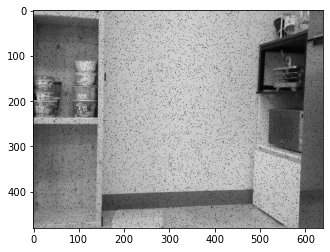

In [54]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim

def add_random_noise(image, seed=0):
    np.random.seed(seed)
    # 임의의 잡음 추가: 임펄스 잡음과 가우시안 잡음
    noise_types = ['s&p', 'gaussian']
    noise_type = np.random.choice(noise_types)

    if noise_type == 's&p':
        row, col = image.shape
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_type == 'gaussian':
        mean = 0
        var = 0.1
        sigma = var ** 0.5
        gaussian = np.random.normal(mean, sigma, image.shape)
        noisy_image = np.clip(image + gaussian, 0, 255)
        return noisy_image.astype(np.uint8)
    
def adjust_brightness_contrast(image, brightness=0, contrast=0,seed=0):
    v = np.arange(-30, 30, 5)
    brightness = np.random.choice(v)
    contrast = np.random.choice(v)
    # 밝기와 대조 조절
    B = brightness / 255.0
    c = contrast / 255.0
    k = np.tan((45 + 44 * c) / 180 * np.pi)

    image = (image - 127.5 * (1 - B)) * k + 127.5 * (1 + B)
    image = np.clip(image, 0, 255)
    return image.astype(np.uint8)


def adjusted_img(image,seed=0) : 
    noise = add_random_noise(image,seed)
    out = adjust_brightness_contrast(noise, -20, 10,seed)
    return out 

edge=find_edges(frame)

res = adjusted_img(frame_gray)
adj_edge = find_edges(res)

print(calculate_metrics(edge, adj_edge))

plt.imshow(res, cmap='gray')

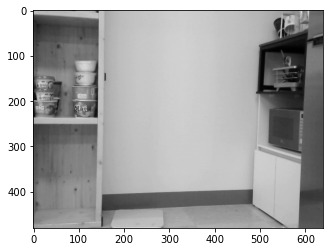

In [55]:
plt.imshow(frame_gray, cmap='gray')

## Grid Search 를 통한 Edge Detector, 하이퍼 파라미터 검출

In [56]:
import cv2
import numpy as np
from itertools import product

radius = 5  # 필터의 반경
eps = 0.1   # 정규화 항

# def edge_detection(image, filter_type, kernel_size):
#     if len(image.shape) == 3 :
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else :
#         gray = image.copy()
#     if filter_type == 'gauss' : 
#         blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
#     elif filter_type == 'guided' :
#         blur = cv2.ximgproc.guidedFilter(guide=gray.copy(), src=gray, radius=kernel_size, eps=eps)
#     else : 
#         blur = cv2.medianBlur(gray, kernel_size)
#     return cv2.Canny(blur, 100, 200)

def compute_performance_metric(edge_image, ground_truth):
    # F1, AUC, ESSIM, continuity (엣지 연결성)
    f1, auc = calculate_metrics(edge_image,ground_truth)
    essim = compute_essim(edge_image, ground_truth)
    continuity = measure_continuity(edge_image)
    return f1*0.25 + auc * 0.25 + essim * 0.25 + continuity * 0.25

# # 하이퍼파라미터 범위 설정
# kernel_sizes=[3,5,7]

# # 이미지와 기준 진리 데이터 불러오기 (경로 변경 필요)
# GT = find_edges(frame)

# # 그리드 서치 실행
# best_score = 0
# best_params = {}

# res = adjusted_img(frame_gray)

# for ksize in kernel_sizes:
#     edges = edge_detection(res, 'gauss',ksize)
    
#     score = compute_performance_metric(edges, GT)

#     if score > best_score:
#         best_score = score
#         best_params = {"kernel_size" : ksize}

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

In [57]:
def auto_canny(img, sigma=0.33) : 
#     img = cv2.GaussianBlur(img, (3, 3), 0)
    v = np.median(img)
#     print(f"Average brightness:{np.mean(img):.2f}") # 평균 밝기 계산 
#     print(f"Bright Contrast:{np.std(img):.2f}") # 대조 값
    lower = int(max(0, 1.0 - sigma)*v)
    upper = int(min(255, (1.0 + sigma)*v ))
#     print(f"Threshold (lower) {lower} (upper) {upper}")
    edged = cv2.Canny(img, lower, upper)
    return edged

def auto_canny_otsu(image):
    # 오츠의 방법을 사용하여 엣지 검출을 위한 최적의 임계값을 계산
    high_thresh, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
#     print(low_thresh, high_thresh)

    # Canny 엣지 검출 적용
#     blur = cv2.GaussianBlur(image, (3, 3), 0)
    edged = cv2.Canny(image, low_thresh, high_thresh)

    return edged

def edge_detection(image, filter_type, kernel_size, auto_method):
    if len(image.shape) == 3 :
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else :
        gray = image.copy()
        
    if filter_type == 'gauss' : 
        blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    elif filter_type == 'guided' :
        blur = cv2.ximgproc.guidedFilter(guide=gray.copy(), src=gray, radius=kernel_size, eps=eps)
    else : 
        blur = cv2.medianBlur(gray, kernel_size)
        
    if auto_method == 'median' :
        edge = auto_canny(blur)
    else : 
        edge = auto_canny_otsu(blur)
        
    return edge

In [58]:
import warnings
warnings.filterwarnings('ignore')

filter_type = ['gauss', 'median', ] # 'guided']
auto_method = ['median','otsu']
kernel_sizes=[5,7,9]
# 
GT = find_edges(frame)

# 그리드 서치 실행
best_score = 0
best_params = {}


for f, ksize, m in product(filter_type, kernel_sizes, auto_method) :
    # 각 조합마다 10번 수행, 평균 도출
    print('Finding Best Params . . .')
    rand_scores = 0  
    for i in range(10) :
        rand_img = adjusted_img(frame_gray, seed=i)
        rand_edge = edge_detection(rand_img, f, ksize, m)
        rand_scores += compute_performance_metric(rand_edge, GT)
        
    rand_scores = rand_scores / 10 

    if rand_scores > best_score:
        best_score = rand_scores
        best_params = {"kernel_size" : ksize, "filter_type" : f,
                      'auto_method' : m}
print('=' * 25)
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Finding Best Params . . .
Best Parameters: {'kernel_size': 5, 'filter_type': 'median', 'auto_method': 'otsu'}
Best Score: 0.5066671606709596


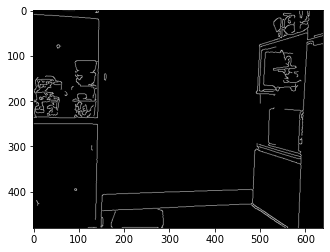

In [59]:
def auto_canny(img, sigma=0.33) : 
#     img = cv2.GaussianBlur(img, (3, 3), 0)
    v = np.median(img)
#     print(f"Average brightness:{np.mean(img):.2f}") # 평균 밝기 계산 
#     print(f"Bright Contrast:{np.std(img):.2f}") # 대조 값
    lower = int(max(0, 1.0 - sigma)*v)
    upper = int(min(255, (1.0 + sigma)*v ))
#     print(f"Threshold (lower) {lower} (upper) {upper}")
    edged = cv2.Canny(img, lower, upper)
    return edged

def canny(img) : 
    return cv2.Canny(img, 100, 200)


def run_best_edge_detector(image, **params) :
#     for key, val in params.items() :
#         print(key, val)
    if params :
        ksize = params['kernel_size']
        ftype = params['filter_type']
        if ftype == 'gauss' :
            blur = cv2.GaussianBlur(image, (ksize, ksize), 0)
        elif ftype == 'median' : 
            blur = cv2.medianBlur(image, ksize)
        else :
            blur = image.copy()
        
        if auto_method == 'median' : 
            edge = auto_canny(blur)
        else :
            edge = auto_canny_otsu(blur)
    else :
        edge = canny(image)
    return edge
    
edge_best = run_best_edge_detector(frame_gray, **best_params)
plt.imshow(edge_best,cmap='gray')

In [60]:
import numpy as np

def get_angle(line):
    x1, y1, x2, y2 = line[0]
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def get_midpoint(line):
    x1, y1, x2, y2 = line[0]
    return ((x1 + x2) / 2, (y1 + y2) / 2)

def get_line_length(line):
    x1, y1, x2, y2 = line[0]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def distance_between_points(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def filter_lines(lines, angle_threshold, dist_threshold):
    filtered_lines = []
    used = [False] * len(lines)

    for i in range(len(lines)):
        if not used[i]:
            max_length = get_line_length(lines[i])
            selected_line = lines[i]
            angle_i = get_angle(lines[i])
            midpoint_i = get_midpoint(lines[i])
            used[i] = True

            for j in range(i + 1, len(lines)):
                if not used[j]:
                    angle_j = get_angle(lines[j])
                    if abs(angle_i - angle_j) <= angle_threshold:
                        midpoint_j = get_midpoint(lines[j])
                        if distance_between_points(midpoint_i, midpoint_j) < dist_threshold:
                            length = get_line_length(lines[j])
                            if length > max_length:
                                selected_line = lines[j]
                                max_length = length
                            used[j] = True
            filtered_lines.append(selected_line)

    return filtered_lines

## hough line 검출 

In [61]:
# def auto_canny_otsu(image, ksize=(5, 5)):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     high_thresh, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     low_thresh = 0.5 * high_thresh

#     # Canny 엣지 검출 적용
#     blur = cv2.GaussianBlur(gray, ksize, 0)
#     edged = cv2.Canny(blur, low_thresh, high_thresh)

#     return edged

def calculate_angle(x1, y1, x2, y2):
    return np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi

# def find_intersection(line1, line2):
#     """ 두 선분의 교차점을 계산합니다. """
#     x1, y1, x2, y2 = line1[0]
#     x3, y3, x4, y4 = line2[0]

#     # 선분의 방정식으로부터 A, B, C 계수를 계산
#     A1 = y2 - y1
#     B1 = x1 - x2
#     C1 = A1 * x1 + B1 * y1
#     A2 = y4 - y3
#     B2 = x3 - x4
#     C2 = A2 * x3 + B2 * y3

#     # 행렬식 계산
#     determinant = A1 * B2 - A2 * B1
#     if determinant == 0:
#         # 두 선분이 평행인 경우
#         return None
#     else:
#         # 교차점 계산
#         x = (B2 * C1 - B1 * C2) / determinant
#         y = (A1 * C2 - A2 * C1) / determinant
#         return int(x), int(y)

# def find_new_points(old_frame):
#     # 새로운 코너점을 검출하는 함수
#     edges = auto_canny_otsu(old_frame)
#     lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=200,
#                            maxLineGap=200)
#     new_points = []
#     if lines is not None :
#         filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
#     if filtered_lines is not None :
#         for line in filtered_lines:
#             x1, y1, x2, y2 = line[0]
#             new_points.append([x1, y1])
#             new_points.append([x2, y2])
#             angle = calculate_angle(x1, y1, x2, y2)               
            
#             for i in range(len(lines)):
#                 for j in range(i + 1, len(lines)):
#                     intersect = find_intersection(lines[i], lines[j])
#                     if intersect:
#                         new_points.append(intersect)
    
#     return np.array(new_points, dtype=np.float32).reshape(-1, 1, 2)

# cap = cv2.VideoCapture(1)


# # Lucas-Kanade 파라미터
# lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# # 첫 프레임 처리 및 코너점 검출
# ret, old_frame = cap.read()
# old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
# p0 = find_new_points(old_frame)
# frame_idx = 0
# height, width = old_gray.shape

# angle_threshold = 10  # 각도 임계
# dist_threshold = 20   # 거리 임계


# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     temp = frame.copy()
#     frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     edges = auto_canny_otsu(frame)
#      # 옵티컬 플로우 계산
#     p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

#     # 좋은 추적 포인트 선택
#     good_new = p1[st == 1].reshape(-1, 2)
#     good_old = p0[st == 1].reshape(-1, 2)

#     # 프레임 밖으로 나간 포인트 제거
#     inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
#                    (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
#     good_new = good_new[inside_frame]
    
#     # 포인트 추적 시각화
#     for point in good_new:
#         a, b = point.ravel()
#         a, b = int(a), int(b)
#         cv2.circle(frame, (a, b), 5, (0, 255, 0), -1)
#         cv2.circle(edges, (a, b), 5, (0, 255, 0), -1)
        
    
#     # 일정 간격으로 새로운 포인트 추가
#     if frame_idx % 30 == 0 and len(good_new) < 50 : # 예: 매 30 프레임마다 새 포인트 검출
#         new_p = find_new_points(temp)
#         if len(new_p) > 0:
#             new_p = new_p.reshape(-1, 2)  # new_p를 2차원 배열로 변환
#             good_new = np.vstack((good_new, new_p))  # 배열을 연결
    

#     lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=200,
#                            maxLineGap=200)
    
#     if lines is not None :
#         filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
#     if filtered_lines is not None :
#         for line in filtered_lines:
#             x1, y1, x2, y2 = line[0]
#             angle = calculate_angle(x1, y1, x2, y2)               
#             if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
#                 cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
#             else :
#                 cv2.line(frame, (x1, y1), (x2, y2), (255,0, 0), 3)
                
#     cv2.imshow('Frame with Optical Flow', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

#     # 다음 반복을 위해 현재 프레임과 포인트 업데이트
#     old_gray = frame_gray.copy()
#     p0 = good_new.reshape(-1, 1, 2)
#     frame_idx += 1

# cap.release()
# cv2.destroyAllWindows()

In [157]:
min_line_length = 200
max_line_gap = 200
# def auto_canny_otsu(image, ksize=(5, 5)):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     high_thresh, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     low_thresh = 0.5 * high_thresh

#     # Canny 엣지 검출 적용
#     blur = cv2.GaussianBlur(gray, ksize, 0)
#     edged = cv2.Canny(blur, low_thresh, high_thresh)

#     return edged

# def calculate_angle(x1, y1, x2, y2):
#     return np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi

# def find_intersection(line1, line2):
#     """ 두 선분의 교차점을 계산합니다. """
#     x1, y1, x2, y2 = line1[0]
#     x3, y3, x4, y4 = line2[0]

#     # 선분의 방정식으로부터 A, B, C 계수를 계산
#     A1 = y2 - y1
#     B1 = x1 - x2
#     C1 = A1 * x1 + B1 * y1
#     A2 = y4 - y3
#     B2 = x3 - x4
#     C2 = A2 * x3 + B2 * y3

#     # 행렬식 계산
#     determinant = A1 * B2 - A2 * B1
#     if determinant == 0:
#         # 두 선분이 평행인 경우
#         return None
#     else:
#         # 교차점 계산
#         x = (B2 * C1 - B1 * C2) / determinant
#         y = (A1 * C2 - A2 * C1) / determinant
#         return int(x), int(y)

# def find_new_points(old_frame):
#     # 새로운 코너점을 검출하는 함수
#     gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
#     edges = run_best_edge_detector(gray)
#     lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=200,
#                            maxLineGap=200)
#     new_points = []
#     if lines is not None :
#         filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
#     if filtered_lines is not None :
#         for line in filtered_lines:
#             x1, y1, x2, y2 = line[0]
#             new_points.append([x1, y1])
#             new_points.append([x2, y2])
#             angle = calculate_angle(x1, y1, x2, y2)               
            
#             for i in range(len(lines)):
#                 for j in range(i + 1, len(lines)):
#                     intersect = find_intersection(lines[i], lines[j])
#                     if intersect:
#                         new_points.append(intersect)
    
#     return np.array(new_points, dtype=np.float32).reshape(-1, 1, 2)

## Hough line with Best params

In [146]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def auto_canny_otsu(image, ksize=(5, 5)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    high_thresh, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
    # Canny 엣지 검출 적용
    blur = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blur, low_thresh, high_thresh)
    return edged

def get_angle(line):
    x1, y1, x2, y2 = line[0]
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def get_midpoint(line):
    x1, y1, x2, y2 = line[0]
    return ((x1 + x2) / 2, (y1 + y2) / 2)

def get_line_length(line):
    x1, y1, x2, y2 = line[0]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def distance_between_points(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def filter_lines(lines, angle_threshold, dist_threshold):
    filtered_lines = []
    used = [False] * len(lines)

    for i in range(len(lines)):
        if not used[i]:
            max_length = get_line_length(lines[i])
            selected_line = lines[i]
            angle_i = get_angle(lines[i])
            midpoint_i = get_midpoint(lines[i])
            used[i] = True

            for j in range(i + 1, len(lines)):
                if not used[j]:
                    angle_j = get_angle(lines[j])
                    if abs(angle_i - angle_j) <= angle_threshold:
                        midpoint_j = get_midpoint(lines[j])
                        if distance_between_points(midpoint_i, midpoint_j) < dist_threshold:
                            length = get_line_length(lines[j])
                            if length > max_length:
                                selected_line = lines[j]
                                max_length = length
                            used[j] = True
            filtered_lines.append(selected_line)

    return filtered_lines


def find_intersection(line1, line2):
    """ 두 선분의 교차점을 계산합니다. """
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]

    # 선분의 방정식으로부터 A, B, C 계수를 계산
    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1
    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3

    # 행렬식 계산
    determinant = A1 * B2 - A2 * B1
    if determinant == 0:
        # 두 선분이 평행인 경우
        return None
    else:
        # 교차점 계산
        x = (B2 * C1 - B1 * C2) / determinant
        y = (A1 * C2 - A2 * C1) / determinant
        return int(x), int(y)


    
def find_new_points(frame, angle_threshold, dist_threshold) : 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = run_best_edge_detector(gray)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=min_line_length,
                           maxLineGap=max_line_gap)
    new_points = []
    filtered_lines = None
    if lines is not None :
        filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
    if filtered_lines is not None :
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            new_points.append([x1, y1])
            new_points.append([x2, y2])
            
        lines = filtered_lines.copy()  
    
    return new_points, lines
    
def is_point_on_valid_line(point, lines, threshold=10): # threshold=10
    for line in lines:
        x1, y1, x2, y2 = line[0]
#         if x2 - x1 == 0:
#             return x == x1

#         # 기울기(m)와 y절편(b) 계산
#         m = (y2 - y1) / (x2 - x1)
#         b = y1 - m * x1

#         # 점이 직선의 방정식을 만족하는지 확인
#         return y == m * x + b
        dist = cv2.pointPolygonTest(np.array([[x1, y1], [x2, y2]]), (point[0], point[1]), True)
#         result = cv2.pointPolygonTest(np.array([[x1, y1], [x2, y2]]), (point[0], point[1]), False)
#         if dist == -1 or dist == 0 :
#             return True
        if abs(dist) < threshold:
            return True
    return False

def remove_close_points(points, threshold):
    valid_points = []
    for i, point in enumerate(points):
        too_close = False
        for j, other_point in enumerate(points):
            if i != j and distance_between_points(point, other_point) < threshold:
                too_close = True
                break
        if not too_close:
            valid_points.append(point)
    return np.array(valid_points)

In [106]:
lk_params = dict(winSize=(21, 21), maxLevel=2, 
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
                           10, 0.03))

angle_threshold = 15 # 중복제거 선 각도 임계
dist_threshold = 50   # 중복제거 선 거리 임계
threshold_distance = 30 # 중복제거 점간 거리 임계

In [33]:
# camera initiation 
cap = cv2.VideoCapture(1)

In [38]:
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0, _ = find_new_points(old_frame, angle_threshold, dist_threshold)

# print(p0)
threshold_distance = 15  # 너무 가까운 점 제거
p0 = np.array(p0,dtype=np.float32)
p0 = remove_close_points(p0, threshold_distance)
frame_idx = 0
height, width = old_gray.shape

# 프레임 밖으로 나간 포인트 제거
inside_frame = (p0[:, 0] > 0) & (p0[:, 0] < frame.shape[1]) & \
               (p0[:, 1] > 0) & (p0[:, 1] < frame.shape[0])
p0 = p0[inside_frame]
p0 = np.array(p0, dtype=np.float32).reshape(-1, 1, 2)
print("초기 시작점 개수 :",len(p0))

초기 시작점 개수 : 6


In [39]:
import time
while True:
    ret, frame = cap.read()
    start = time.time()
    if not ret:
        break
    window = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = run_best_edge_detector(frame)
     # 옵티컬 플로우 계산
    try : 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # 좋은 추적 포인트 선택
        good_new = p1[st == 1].reshape(-1, 2)
        good_old = p0[st == 1].reshape(-1, 2)
        
        # 일정 간격으로 새로운 포인트 추가
    #     if len(good_new) < 50 or frame_idx % 30 == 0  : # frame_idx % 30 == 0 
        new_p, lines = find_new_points(frame, angle_threshold, dist_threshold)
        new_p =  np.array(new_p, dtype=np.float32).reshape(-1, 1, 2)
        if len(new_p) > 0:
            new_p = new_p.reshape(-1, 2)  # new_p를 2차원 배열로 변환
            good_new = np.vstack((good_new, new_p))  # 배열을 연결   

        # 프레임 밖으로 나간 포인트 제거
        inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
                       (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
        good_new = good_new[inside_frame]

        valid_points = [] # 유효한 포인트만 필터링

        for point in good_new:
            if is_point_on_valid_line(point, lines):
                valid_points.append(point)

#         for i in range(len(lines)):
#             for j in range(i + 1, len(lines)):
#                 intersect = find_intersection(lines[i], lines[j])
#                 if intersect:
#                     valid_points.append(intersect)

        # 근접 포인트 제거 
        valid_points = np.array(valid_points)
        valid_points = remove_close_points(valid_points, threshold_distance)

    #     print("number of valid points :",len(valid_points))

        # 포인트 추적 시각화
        for point in valid_points :
            a, b = point.ravel()
            a, b = int(a), int(b)
            cv2.circle(window, (a, b), 5, (0, 255, 0), -1)


    except :
        pass
    
    finally : 
        
        if lines is not None :
            for line in lines :
                x1, y1, x2, y2 = line[0]
                angle = calculate_angle(x1, y1, x2, y2)               
                if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                    cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
                else :
                    cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)   
        
        cv2.imshow('Frame with Optical Flow', cv2.hconcat([window, cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)]))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # 현재 프레임과 포인트 업데이트
        old_gray = frame_gray.copy()
        p0 = np.array(valid_points, dtype=np.float32).reshape(-1, 1, 2)
    #     print(p0)
    #     print(p0.shape)
        frame_idx += 1
    
# cap.release()
cv2.destroyAllWindows()

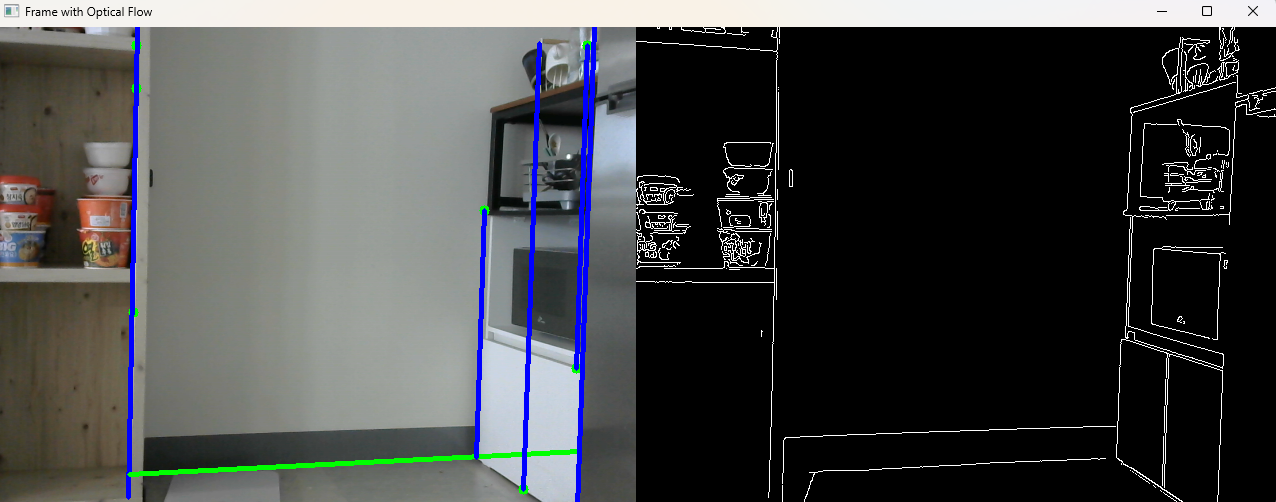

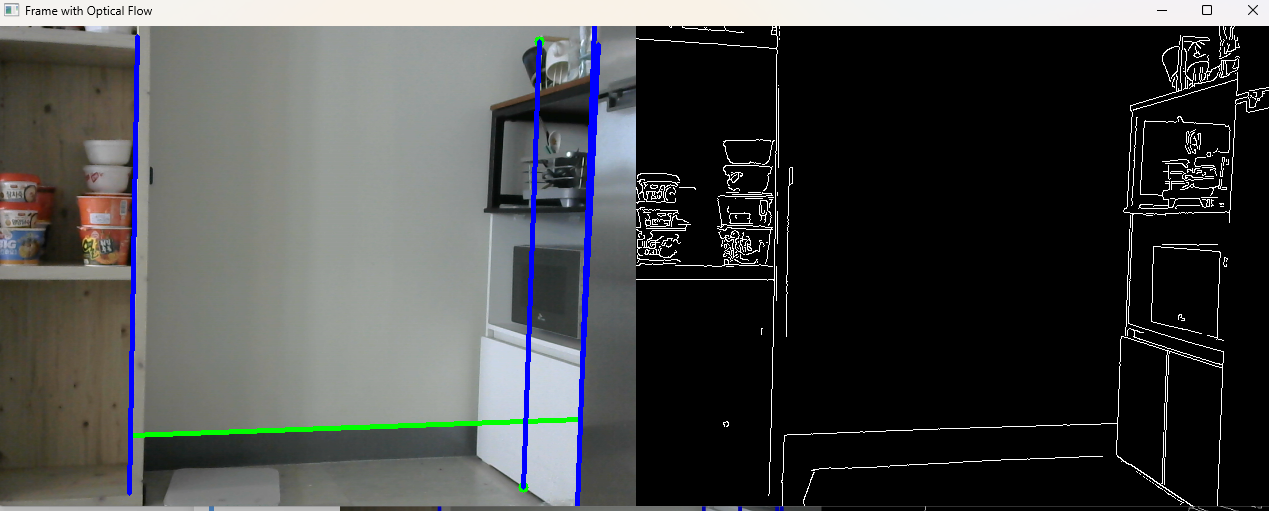

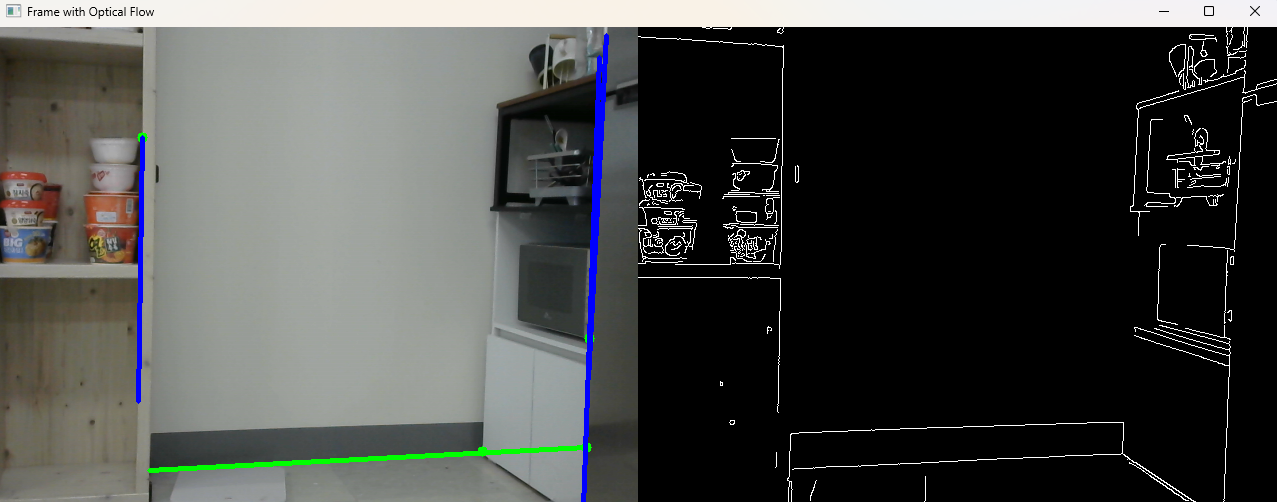

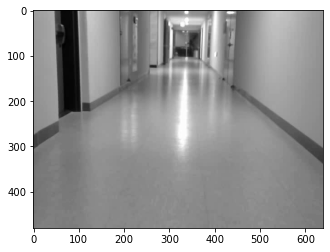

In [167]:
# camera initiation 
cap = cv2.VideoCapture("./output4.mp4")

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
plt.imshow(old_gray,cmap='gray')

초기 시작점 개수 : 6
[[[276.  33.]]

 [[638. 337.]]

 [[105. 215.]]

 [[ 48.  16.]]

 [[ 57. 266.]]

 [[447.  26.]]]


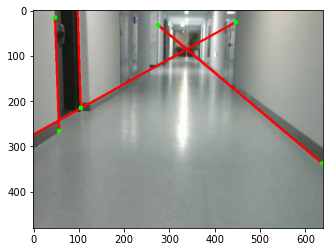

In [168]:
window=old_frame.copy()
p0, lines = find_new_points(old_frame, angle_threshold, dist_threshold)
if lines is not None :
    for line in lines :
        x1, y1, x2, y2 = line[0]
        angle = calculate_angle(x1, y1, x2, y2)               
        if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
            cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
        else :
            cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)   
            
threshold_distance = 15  # 너무 가까운 점 제거
p0 = np.array(p0,dtype=np.float32)
p0 = remove_close_points(p0, threshold_distance)
frame_idx = 0
height, width = old_gray.shape

# 프레임 밖으로 나간 포인트 제거
inside_frame = (p0[:, 0] > 0) & (p0[:, 0] < old_frame.shape[1]) & \
               (p0[:, 1] > 0) & (p0[:, 1] < old_frame.shape[0])
p0 = p0[inside_frame]
p0 = np.array(p0, dtype=np.float32).reshape(-1, 1, 2)
print("초기 시작점 개수 :",len(p0))

print(p0)

# 포인트 추적 시각화
for point in p0 :
    a, b = point.ravel()
    a, b = int(a), int(b)
    cv2.circle(window, (a, b), 5, (0, 255, 0), -1)


    
plt.imshow(window)

In [169]:
while True:
    ret, frame = cap.read()
    start = time.time()
    if not ret:
        break
    window = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = run_best_edge_detector(frame)
     # 옵티컬 플로우 계산
    try : 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # 좋은 추적 포인트 선택
        good_new = p1[st == 1].reshape(-1, 2)
        good_old = p0[st == 1].reshape(-1, 2)
        
        # 일정 간격으로 새로운 포인트 추가
    #     if len(good_new) < 50 or frame_idx % 30 == 0  : # frame_idx % 30 == 0 
        new_p, lines = find_new_points(frame, angle_threshold, dist_threshold)
        new_p =  np.array(new_p, dtype=np.float32).reshape(-1, 1, 2)
        if len(new_p) > 0:
            new_p = new_p.reshape(-1, 2)  # new_p를 2차원 배열로 변환
            good_new = np.vstack((good_new, new_p))  # 배열을 연결   

        # 프레임 밖으로 나간 포인트 제거
        inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
                       (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
        good_new = good_new[inside_frame]

        valid_points = [] # 유효한 포인트만 필터링

        for point in good_new:
            if is_point_on_valid_line(point, lines):
                valid_points.append(point)

#         for i in range(len(lines)):
#             for j in range(i + 1, len(lines)):
#                 intersect = find_intersection(lines[i], lines[j])
#                 if intersect:
#                     valid_points.append(intersect)

        # 근접 포인트 제거 
        valid_points = np.array(valid_points)
        valid_points = remove_close_points(valid_points, threshold_distance)

#         print("number of valid points :",len(valid_points))

        # 포인트 추적 시각화
        for point in valid_points :
            a, b = point.ravel()
            a, b = int(a), int(b)
            cv2.circle(window, (a, b), 5, (0, 255, 0), -1)


    except :
        pass
    
    finally : 
        
        if lines is not None :
            for line in lines :
                x1, y1, x2, y2 = line[0]
                angle = calculate_angle(x1, y1, x2, y2)               
                if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                    cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
                else :
                    cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)   
        
        cv2.imshow('Frame with Optical Flow', cv2.hconcat([window, cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)]))

        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

        # 현재 프레임과 포인트 업데이트
        old_gray = frame_gray.copy()
        p0 = np.array(valid_points, dtype=np.float32).reshape(-1, 1, 2)
    #     print(p0)
    #     print(p0.shape)
        frame_idx += 1
    
cap.release()
cv2.destroyAllWindows()

In [161]:
# camera initiation 
cap = cv2.VideoCapture("./output2.mp4")

ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
window=old_frame.copy()
p0, lines = find_new_points(old_frame, angle_threshold, dist_threshold)
if lines is not None :
    for line in lines :
        x1, y1, x2, y2 = line[0]
        angle = calculate_angle(x1, y1, x2, y2)               
        if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
            cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
        else :
            cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)   
            
threshold_distance = 15  # 너무 가까운 점 제거
p0 = np.array(p0,dtype=np.float32)
p0 = remove_close_points(p0, threshold_distance)
frame_idx = 0
height, width = old_gray.shape

# 프레임 밖으로 나간 포인트 제거
inside_frame = (p0[:, 0] > 0) & (p0[:, 0] < old_frame.shape[1]) & \
               (p0[:, 1] > 0) & (p0[:, 1] < old_frame.shape[0])
p0 = p0[inside_frame]
p0 = np.array(p0, dtype=np.float32).reshape(-1, 1, 2)
print("초기 시작점 개수 :",len(p0))

# print(p0)

# 포인트 추적 시각화
for point in p0 :
    a, b = point.ravel()
    a, b = int(a), int(b)
    cv2.circle(window, (a, b), 5, (0, 255, 0), -1)


    
while True:
    ret, frame = cap.read()
    start = time.time()
    if not ret:
        break
    window = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = run_best_edge_detector(frame)
     # 옵티컬 플로우 계산
    try : 
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # 좋은 추적 포인트 선택
        good_new = p1[st == 1].reshape(-1, 2)
        good_old = p0[st == 1].reshape(-1, 2)
        
        # 일정 간격으로 새로운 포인트 추가
    #     if len(good_new) < 50 or frame_idx % 30 == 0  : # frame_idx % 30 == 0 
        new_p, lines = find_new_points(frame, angle_threshold, dist_threshold)
        new_p =  np.array(new_p, dtype=np.float32).reshape(-1, 1, 2)
        if len(new_p) > 0:
            new_p = new_p.reshape(-1, 2)  # new_p를 2차원 배열로 변환
            good_new = np.vstack((good_new, new_p))  # 배열을 연결   

        # 프레임 밖으로 나간 포인트 제거
        inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
                       (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
        good_new = good_new[inside_frame]

        valid_points = [] # 유효한 포인트만 필터링

        for point in good_new:
            if is_point_on_valid_line(point, lines):
                valid_points.append(point)

#         for i in range(len(lines)):
#             for j in range(i + 1, len(lines)):
#                 intersect = find_intersection(lines[i], lines[j])
#                 if intersect:
#                     valid_points.append(intersect)

        # 근접 포인트 제거 
        valid_points = np.array(valid_points)
        valid_points = remove_close_points(valid_points, threshold_distance)

#         print("number of valid points :",len(valid_points))

        # 포인트 추적 시각화
        for point in valid_points :
            a, b = point.ravel()
            a, b = int(a), int(b)
            cv2.circle(window, (a, b), 5, (0, 255, 0), -1)


    except :
        pass
    
    finally : 
        
        if lines is not None :
            for line in lines :
                x1, y1, x2, y2 = line[0]
                angle = calculate_angle(x1, y1, x2, y2)               
                if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                    cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
                else :
                    cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)   
        
        cv2.imshow('Frame with Optical Flow', cv2.hconcat([window, cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)]))

        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

        # 현재 프레임과 포인트 업데이트
        old_gray = frame_gray.copy()
        p0 = np.array(valid_points, dtype=np.float32).reshape(-1, 1, 2)
    #     print(p0)
    #     print(p0.shape)
        frame_idx += 1
    
cap.release()
cv2.destroyAllWindows()

초기 시작점 개수 : 7


In [3]:
# import cv2

# # 비디오 캡처 객체 초기화
# cap = cv2.VideoCapture(1)  # '0'은 기본 카메라를 의미합니다. 다른 소스를 사용하려면 경로나 다른 인덱스를 지정하세요.

# # 비디오 코덱 및 출력 설정
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 코덱
# fps = 20.0  # 저장할 비디오의 FPS
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

# # 비디오 캡처 및 저장
# while cap.isOpened():
#     ret, frame = cap.read()
    
#     if ret:
#         out.write(frame)  # 프레임을 출력 파일에 쓰기

#         # 화면에 프레임 표시 (선택사항)
#         cv2.imshow('Frame', frame)

#         # 'q'를 누르면 루프 탈출
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
#     else:
#         break

# # 모든 자원 해제
# cap.release()
# out.release()
# cv2.destroyAllWindows()